In [7]:
import pandas as pd

# 读取Sensing
df = pd.read_csv("archive/Sensing/sensing.csv")

# 选择audio相关列
selected_columns = [
    'uid',
    'day',
    'audio_amp_mean_ep_0',
    'audio_amp_std_ep_0',
    'audio_convo_duration_ep_0',
    'audio_convo_num_ep_0',
    'audio_voice_ep_0',
    'call_in_duration_ep_0',
    'call_in_num_ep_0',
    'call_miss_num_ep_0',
    'call_out_duration_ep_0',
    'call_out_num_ep_0'
]

# 创建DF
audio_and_call_df = df[selected_columns].copy()
audio_and_call_df.to_csv("audio_and_call.csv", index=False)


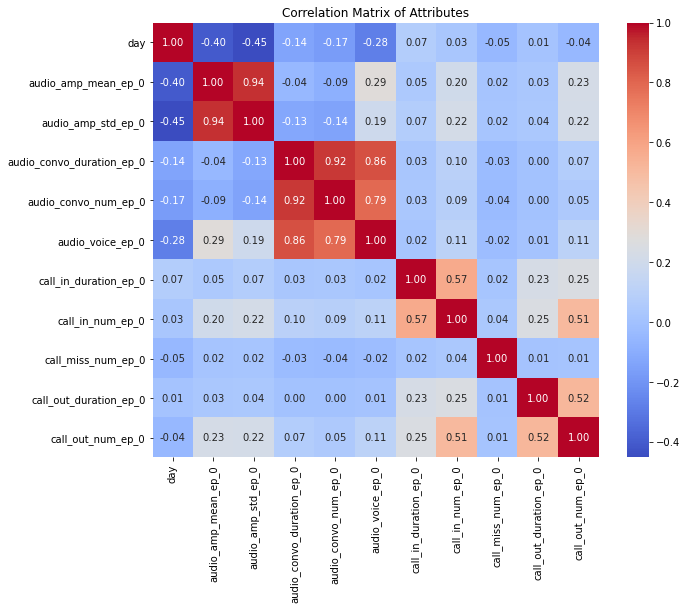

In [8]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("audio_and_call.csv")

# 计算audio and call组内相关性
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attributes')
plt.show()


只有num和duration之间有相关性，不可压缩，发现有很多行是0或者null，删除这些行

In [10]:
import pandas as pd

df = pd.read_csv("audio_and_call.csv")

# 清洗
df = df[(df[['audio_amp_mean_ep_0',
             'audio_amp_std_ep_0',
             'audio_convo_duration_ep_0',
             'audio_convo_num_ep_0',
             'audio_voice_ep_0', # 5.15之前都把这个特征忘了啊啊啊啊啊啊啊啊
             'call_in_duration_ep_0',
             'call_in_num_ep_0',
             'call_miss_num_ep_0',
             'call_out_duration_ep_0',
             'call_out_num_ep_0']] != 0).all(axis=1)]

df.to_csv("cleaned_audio_and_call.csv", index=False)


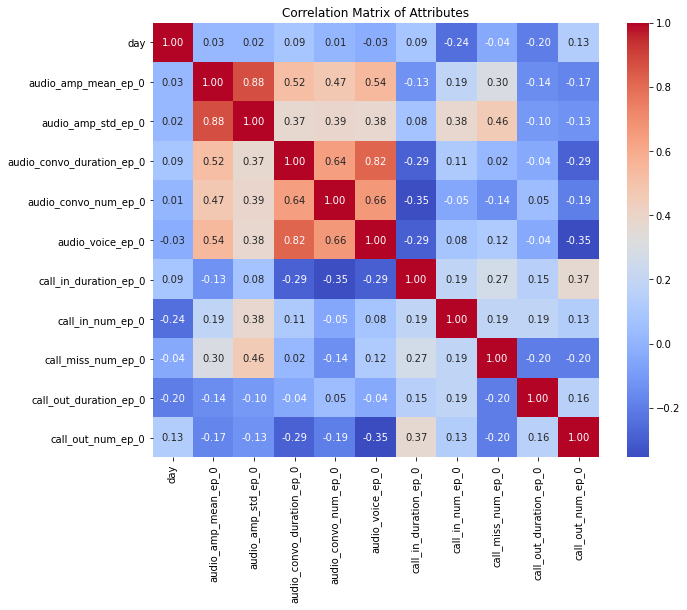

In [11]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

df = pd.read_csv("cleaned_audio_and_call.csv")

# 清洗后的相关性
correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attributes')
plt.show()

audio的相关性变得显著了，call的基本消失了，观察发现是call的记录很少，故排除其和EMA相关性的分析

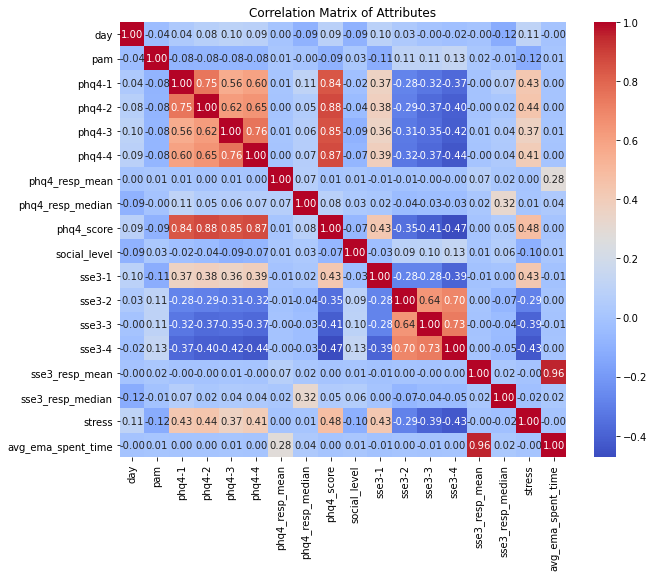

In [12]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

# 读取ema
df = pd.read_csv("archive/EMA/general_ema.csv")

correlation_matrix = df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attributes')
plt.show()

phq4_score和分项之间有相关性，可压缩，但疑点是social level和任何值都不相关

In [15]:
import pandas as pd

# 只提取音频
audio_and_call_df = pd.read_csv("cleaned_audio_and_call.csv", 
                                usecols=['uid', 'day', 
                                         'audio_amp_mean_ep_0',
                                         'audio_amp_std_ep_0',
                                         'audio_convo_duration_ep_0',
                                         'audio_convo_num_ep_0',
                                         'audio_voice_ep_0'])

# 从 archive/EMA/general_ema.csv 中提取感兴趣的
ema_df = pd.read_csv("archive/EMA/general_ema.csv", 
                     usecols=['uid', 'day', 'phq4_score'])

# 按uid和day合并
merged_df = pd.merge(audio_and_call_df, ema_df, on=['uid', 'day'], how='inner')

# 保存
merged_df.to_csv("audio_phq4.csv", index=False)


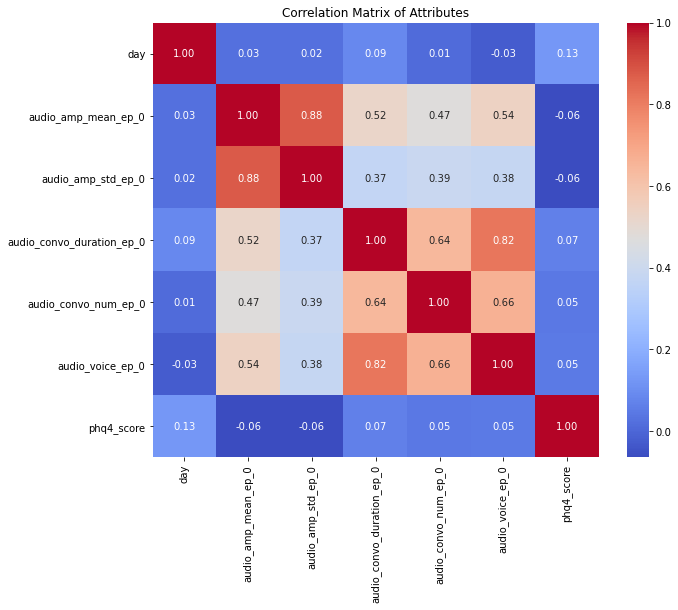

In [16]:
import pandas as pd
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt

merged_df = pd.read_csv("audio_phq4.csv")

columns_to_normalize = ['audio_amp_mean_ep_0', 'audio_amp_std_ep_0', 'audio_convo_duration_ep_0', 'audio_convo_num_ep_0', 'audio_voice_ep_0','phq4_score']

# 使用 Min-Max Normalization 进行正则化
scaler = MinMaxScaler()
merged_df[columns_to_normalize] = scaler.fit_transform(merged_df[columns_to_normalize])

# 相关性
correlation_matrix = merged_df.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Matrix of Attributes')
plt.show()


试试时间偏移...跑不出来太久了

编码拟合

In [1]:
#随机森林
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error

data_df = pd.read_csv("audio_phq4.csv")

os.makedirs("audio_phq4_normalized_regression", exist_ok=True)

unique_uids = data_df['uid'].unique()

mse_list_rf = []

# 循环处理每个 uid
for uid in unique_uids:
    uid_data = data_df[data_df['uid'] == uid]
    
    if 'phq4_score' not in uid_data.columns:
        continue
    
    uid_data = uid_data.dropna(subset=['phq4_score'])
    
    uid_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    uid_data.fillna(0, inplace=True)
    
    # 音频特征
    audio_features = uid_data[['audio_amp_mean_ep_0', 'audio_amp_std_ep_0', 'audio_convo_duration_ep_0', 'audio_convo_num_ep_0','audio_voice_ep_0']]
    
    # 插值处理 phq4_score
    phq4_score = uid_data['phq4_score']
    phq4_score_interpolated = phq4_score.interpolate(method='linear')
    
    # 正则化
    scaler_audio = StandardScaler()
    scaler_phq4 = StandardScaler()
    
    audio_features_normalized = scaler_audio.fit_transform(audio_features)
    phq4_score_normalized = scaler_phq4.fit_transform(phq4_score_interpolated.values.reshape(-1, 1)).flatten()
    
    # 降维
    pca = PCA(n_components=1)
    audio_vector_reduced = pca.fit_transform(audio_features_normalized)
    
    # 训练随机森林回归模型
    rf_model = RandomForestRegressor(random_state=42)
    rf_model.fit(audio_features_normalized, phq4_score_normalized)
    
    # 预测 phq4_score
    predicted_phq4_score_normalized = rf_model.predict(audio_features_normalized)
    
    # 计算mse
    mse = mean_squared_error(phq4_score_normalized, predicted_phq4_score_normalized)
    mse_list_rf.append(mse)
    print(f"UID: {uid}, MSE: {mse}")
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(phq4_score_normalized, label='Normalized phq4_score', color='blue')
    
    ax.plot(predicted_phq4_score_normalized, label='Predicted phq4_score', linestyle='--', color='green')
    
    mean_audio_features_normalized = np.mean(audio_features_normalized, axis=1)
    ax.plot(mean_audio_features_normalized, label='Mean of normalized audio_features', linestyle=':', color='red')
    
    # 添加标题和图例
    ax.set_title(f"UID: {uid}")
    ax.legend()
    
    # 保存图形文件
    plt.savefig(f"audio_phq4_normalized_regression/{uid}_plot_normalized_regression.png")
    
    # 显示图形
    #plt.show()
    ''' # 为缩小代码体积，不保存图片

# 计算所有用户的均方误差的平均值
average_mse_rf = np.mean(mse_list_rf)
print(f"Average MSE (Random Forest): {average_mse_rf}")
print(f"Sum MSE (Random Forest): {np.sum(mse_list_rf)}")


UID: 1ff6d7f34acb354430e7323a35ff7703, MSE: 0.189847509578544
UID: fa394f6d3d077bd5568fc3bc01580806, MSE: 0.15944500000000003
UID: 596df3c263e97eb09d44a8535ec20ffa, MSE: 0.18415833333333315
UID: ea716dd032aaa0dcf8bfa36b1811917f, MSE: 0.19402417582417572
UID: 3dad5f11680b432159b65838119ab87e, MSE: 0.15386060606060614
UID: a23be0935798553a76b4e74cfc1740f1, MSE: 0.2005261349693251
UID: 791c580346256bca5c697d19170a50b5, MSE: 0.18810020165807806
UID: 46f1dfeda71a865074859c81bb314fd9, MSE: 0.18181229693993228
UID: 3bb377ba0acb7d8916010184df36aa57, MSE: 0.13536688963210686
UID: 8391d8b451084771d0affcc26e34d773, MSE: 0.14541050738599895
UID: 79d8490ab94fc7cd6530b1f22593d708, MSE: 0.11968831168831172
UID: c31fd374e5d8227a31bf8f06f0402b96, MSE: 0.0
UID: 96cf40f9d3b2d69466161000cd69ae5c, MSE: 0.15166999999999978
UID: ab5ee451ce580a761fefd88f7b49a97f, MSE: 0.18767241379310406
UID: 01fb41df0f6c2f69d65db5a38c600b4c, MSE: 0.1413100000000002
UID: c21283c11daebb61004b688f04c27715, MSE: 0.15299947322212

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


UID: e06024d216d36ef2d7cddc8a67cf77a7, MSE: 0.19343976683937827
UID: c703d4732f997328085fad609ecd6656, MSE: 0.17198469101123584
UID: 1c12f39481a6c09da17bd4e6bebed9a2, MSE: 0.1316449626865672
UID: 9e9e21ee5dbdb37ffda3225cd0403d34, MSE: 0.1757874870197301
UID: 59256b077a34f2f4ed7bbf7670e53786, MSE: 0.20160491905354921
UID: 76b564dca3ab4d899e5a30d3cbcb0aac, MSE: 0.18193670454545469
UID: d2c8a48736cfe925440115558db860ee, MSE: 0.17206303236797293
UID: 1fff60a0795f79ab1f9432d2cb1f56ee, MSE: 0.16660256166982904
UID: 34ed21e64b190dc037d35ef7f646feb8, MSE: 0.18117857142857177
UID: a4dde9659b38b613f08b37c0c8bfa9eb, MSE: 0.1715519565217394
UID: 07eab8e219b6a4dcd45167dc216e1189, MSE: 0.21288229426433958
UID: 45555d3305e255895b11695c179a98cd, MSE: 0.15096697571743925
UID: f0db9e3e8b9b5080e5752383cceb34f6, MSE: 0.1696008298755189
UID: 5fa34bfca33d0ced12ea991006fbc934, MSE: 0.23048115942028977
UID: f17129feb37d5dcec17728f50d7beb95, MSE: 0.15963235109717858
UID: 8733d6d19519598608c6dc2f9ee525d7, MSE: 

c:\ProgramData\Anaconda3\lib\site-packages\sklearn\decomposition\_pca.py:461: RuntimeWarning: invalid value encountered in true_divide
  explained_variance_ = (S ** 2) / (n_samples - 1)


UID: 600713d94c8ebe9f12f7d12c6479a131, MSE: 0.1268381964418877
UID: 1df93e607e693903c6fce6054a0a67c5, MSE: 0.1025216925549011
UID: c2d80f95e15e8973a9a943564baea1b7, MSE: 0.11375200000000024
UID: e535002d3f0d00b98ff8a34754d6472b, MSE: 0.15682955548238398
UID: d1075cae00d6198eb840ad42a2df742c, MSE: 0.14772757255936675
UID: 7a5f7cc91bafe10c9708342bb197ea58, MSE: 0.12125077519379857
UID: 2d5d41b5e9a9a5bb7007264230e4c575, MSE: 0.11770437756497976
UID: 84120765740b5395aa49a2feb12fbb43, MSE: 0.1639855308713214
UID: 63e8142ef2fdd89aec0630ce6070831d, MSE: 0.20885122382033838
UID: 0aee9faa6f2d2d24d85d2690f5b2df25, MSE: 0.15683248793370347
UID: 1893420fc2b045e14ef0112c1b079afe, MSE: 0.09084115712074285
UID: b1fed5ab5fbd8a1b2fd93b925849a11c, MSE: 0.18454125000000013
UID: 24e89780f6c9efef9ab28fea842cf620, MSE: 0.18554779344858938
UID: d1cd5ab675681cd980ee4dd212d8c53c, MSE: 0.17381798305547974
UID: 6b22ac2851e90cebdb6bcc50288e031c, MSE: 0.0
UID: 12e0a85ee9819ae1abeca0ccfaa52d13, MSE: 0.2523092105263

In [2]:
#线性回归
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

data_df = pd.read_csv("audio_phq4.csv")

os.makedirs("audio_phq4_linear_regression", exist_ok=True)

unique_uids = data_df['uid'].unique()

mse_list_lr = []

for uid in unique_uids:
    uid_data = data_df[data_df['uid'] == uid]
    
    if 'phq4_score' not in uid_data.columns:
        continue
    
    uid_data = uid_data.dropna(subset=['phq4_score'])
    
    uid_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    uid_data.fillna(0, inplace=True)
    
    audio_features = uid_data[['audio_amp_mean_ep_0', 'audio_amp_std_ep_0', 'audio_convo_duration_ep_0', 'audio_convo_num_ep_0','audio_voice_ep_0']]
    
    phq4_score = uid_data['phq4_score']
    phq4_score_interpolated = phq4_score.interpolate(method='linear')
    
    scaler_audio = StandardScaler()
    scaler_phq4 = StandardScaler()
    
    audio_features_normalized = scaler_audio.fit_transform(audio_features)
    phq4_score_normalized = scaler_phq4.fit_transform(phq4_score_interpolated.values.reshape(-1, 1)).flatten()
    
    lr_model = LinearRegression()
    lr_model.fit(audio_features_normalized, phq4_score_normalized)
    
    predicted_phq4_score_normalized = lr_model.predict(audio_features_normalized)
    
    mse = mean_squared_error(phq4_score_normalized, predicted_phq4_score_normalized)
    mse_list_lr.append(mse)
    print(f"UID: {uid}, MSE (Linear Regression): {mse}")
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(phq4_score_normalized, label='Normalized phq4_score', color='blue')
    
    ax.plot(predicted_phq4_score_normalized, label='Predicted phq4_score (LR)', linestyle='--', color='green')
    
    mean_audio_features_normalized = np.mean(audio_features_normalized, axis=1)
    ax.plot(mean_audio_features_normalized, label='Mean of normalized audio_features', linestyle=':', color='red')
    
    ax.set_title(f"UID: {uid}")
    ax.legend()
    
    plt.savefig(f"audio_phq4_linear_regression/{uid}_plot_linear_regression.png")
    
    #plt.show()
    '''

# 计算所有用户的均方误差的平均值
average_mse_lr = np.mean(mse_list_lr)
print(f"Average MSE (Linear Regression): {average_mse_lr}")
print(f"Sum MSE (LR): {np.sum(mse_list_lr)}")


UID: 1ff6d7f34acb354430e7323a35ff7703, MSE (Linear Regression): 0.8851970621964783
UID: fa394f6d3d077bd5568fc3bc01580806, MSE (Linear Regression): 0.8289772075980729
UID: 596df3c263e97eb09d44a8535ec20ffa, MSE (Linear Regression): 0.9485322123189399
UID: ea716dd032aaa0dcf8bfa36b1811917f, MSE (Linear Regression): 0.3925443298264332
UID: 3dad5f11680b432159b65838119ab87e, MSE (Linear Regression): 0.9007651200658807
UID: a23be0935798553a76b4e74cfc1740f1, MSE (Linear Regression): 0.9049051805448736
UID: 791c580346256bca5c697d19170a50b5, MSE (Linear Regression): 0.9718676675151836
UID: 46f1dfeda71a865074859c81bb314fd9, MSE (Linear Regression): 0.8019829903040414
UID: 3bb377ba0acb7d8916010184df36aa57, MSE (Linear Regression): 0.9061195044702864
UID: 8391d8b451084771d0affcc26e34d773, MSE (Linear Regression): 0.9692622561318711
UID: 79d8490ab94fc7cd6530b1f22593d708, MSE (Linear Regression): 0.819484781130391
UID: c31fd374e5d8227a31bf8f06f0402b96, MSE (Linear Regression): 0.0
UID: 96cf40f9d3b2d69

In [3]:
#GBRT
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np  
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error

data_df = pd.read_csv("audio_phq4.csv")

os.makedirs("audio_phq4_gbrt", exist_ok=True)

unique_uids = data_df['uid'].unique()

mse_list_gbrt = []

for uid in unique_uids:
    uid_data = data_df[data_df['uid'] == uid]
    
    if 'phq4_score' not in uid_data.columns:
        continue
    
    uid_data = uid_data.dropna(subset=['phq4_score'])
    uid_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    uid_data.fillna(0, inplace=True)
    
    audio_features = uid_data[['audio_amp_mean_ep_0', 'audio_amp_std_ep_0', 'audio_convo_duration_ep_0', 'audio_convo_num_ep_0','audio_voice_ep_0']]
    
    phq4_score = uid_data['phq4_score']
    phq4_score_interpolated = phq4_score.interpolate(method='linear')
    
    scaler_audio = StandardScaler()
    scaler_phq4 = StandardScaler()
    
    audio_features_normalized = scaler_audio.fit_transform(audio_features)
    phq4_score_normalized = scaler_phq4.fit_transform(phq4_score_interpolated.values.reshape(-1, 1)).flatten()
    
    gbrt_model = GradientBoostingRegressor(n_estimators=100, random_state=42)
    gbrt_model.fit(audio_features_normalized, phq4_score_normalized)
    
    predicted_phq4_score_normalized = gbrt_model.predict(audio_features_normalized)
    
    mse = mean_squared_error(phq4_score_normalized, predicted_phq4_score_normalized)
    mse_list_gbrt.append(mse)
    print(f"UID: {uid}, MSE (GBRT): {mse}")
    '''
    fig, ax = plt.subplots(figsize=(10, 6))
    
    ax.plot(phq4_score_normalized, label='Normalized phq4_score', color='blue')
    
    ax.plot(predicted_phq4_score_normalized, label='Predicted phq4_score (GBRT)', linestyle='--', color='green')
    
    mean_audio_features_normalized = np.mean(audio_features_normalized, axis=1)
    ax.plot(mean_audio_features_normalized, label='Mean of normalized audio_features', linestyle=':', color='red')
    
    ax.set_title(f"UID: {uid}")
    ax.legend()
    
    plt.savefig(f"audio_phq4_gbrt/{uid}_plot_gbrt.png")
    
    # 显示图形
    #plt.show()
    '''

# 计算所有用户的均方误差的平均值
average_mse_gbrt = np.mean(mse_list_gbrt)
print(f"Average MSE (GBRT): {average_mse_gbrt}")
print(f"Sum MSE (GBRT): {np.sum(mse_list_gbrt)}")


UID: 1ff6d7f34acb354430e7323a35ff7703, MSE (GBRT): 0.0013719367182272884
UID: fa394f6d3d077bd5568fc3bc01580806, MSE (GBRT): 0.005188980025274359
UID: 596df3c263e97eb09d44a8535ec20ffa, MSE (GBRT): 0.0007810706724006839
UID: ea716dd032aaa0dcf8bfa36b1811917f, MSE (GBRT): 7.965391639203439e-10
UID: 3dad5f11680b432159b65838119ab87e, MSE (GBRT): 0.0041602858991868445
UID: a23be0935798553a76b4e74cfc1740f1, MSE (GBRT): 0.004951542118155416
UID: 791c580346256bca5c697d19170a50b5, MSE (GBRT): 0.012670709494206685
UID: 46f1dfeda71a865074859c81bb314fd9, MSE (GBRT): 0.0020294830256787836
UID: 3bb377ba0acb7d8916010184df36aa57, MSE (GBRT): 0.005305068473927449
UID: 8391d8b451084771d0affcc26e34d773, MSE (GBRT): 0.022965081449753632
UID: 79d8490ab94fc7cd6530b1f22593d708, MSE (GBRT): 0.00037990520949975266
UID: c31fd374e5d8227a31bf8f06f0402b96, MSE (GBRT): 0.0
UID: 96cf40f9d3b2d69466161000cd69ae5c, MSE (GBRT): 0.000575202974011845
UID: ab5ee451ce580a761fefd88f7b49a97f, MSE (GBRT): 9.46602793531072e-05
UI

使用GBRT进行预测

In [4]:
from sklearn.model_selection import train_test_split

mse_list_gbrt = []

# 存储预测结果和真实值
predicted_phq4_scores = []
true_phq4_scores = []

for uid in unique_uids:
    uid_data = data_df[data_df['uid'] == uid]
    
    if 'phq4_score' not in uid_data.columns:
        continue
    uid_data = uid_data.dropna(subset=['phq4_score'])
    uid_data.replace([np.inf, -np.inf], np.nan, inplace=True)
    uid_data.fillna(0, inplace=True)
    
    if len(uid_data) < 2:
        print(f"Skipping UID {uid} due to insufficient data for splitting.")
        continue
    
    audio_features = uid_data[['audio_amp_mean_ep_0', 'audio_amp_std_ep_0', 'audio_convo_duration_ep_0', 'audio_convo_num_ep_0','audio_voice_ep_0']]
    
    phq4_score = uid_data['phq4_score']
    phq4_score_interpolated = phq4_score.interpolate(method='linear')
    
    scaler_audio = StandardScaler()
    scaler_phq4 = StandardScaler()
    
    audio_features_normalized = scaler_audio.fit_transform(audio_features)
    phq4_score_normalized = scaler_phq4.fit_transform(phq4_score_interpolated.values.reshape(-1, 1)).flatten()
    
    # 将数据分割为训练集和测试集
    X_train, X_test, y_train, y_test = train_test_split(audio_features_normalized, phq4_score_normalized, test_size=0.2, random_state=42)
    
    gbrt_model = GradientBoostingRegressor(n_estimators=110, random_state=42)
    gbrt_model.fit(X_train, y_train)
    
    # 预测 phq4_score
    predicted_phq4_score_normalized = gbrt_model.predict(X_test)
    
    # 计算均方误差
    mse = mean_squared_error(y_test, predicted_phq4_score_normalized)
    mse_list_gbrt.append(mse)
    print(f"UID: {uid}, MSE (GBRT): {mse}")
    
    predicted_phq4_scores.extend(predicted_phq4_score_normalized)
    true_phq4_scores.extend(y_test)
    '''
    plt.figure(figsize=(14, 7))

    # 实际的标准化 phq4_score
    plt.plot(true_phq4_scores, label='True phq4_score', color='blue')

    # 预测的标准化 phq4_score
    plt.plot(predicted_phq4_scores, label='Predicted phq4_score', linestyle='--', color='green')

    # 添加标题和图例
    plt.title('True vs Predicted phq4_score')
    plt.legend()

    # 显示图形
    plt.show()
    '''

# 计算所有用户的均方误差的平均值
average_mse_gbrt = np.mean(mse_list_gbrt)
print(f"Average MSE (GBRT): {average_mse_gbrt}")




UID: 1ff6d7f34acb354430e7323a35ff7703, MSE (GBRT): 1.302864866385081
UID: fa394f6d3d077bd5568fc3bc01580806, MSE (GBRT): 1.6042292203741753
UID: 596df3c263e97eb09d44a8535ec20ffa, MSE (GBRT): 0.7890601472535579
UID: ea716dd032aaa0dcf8bfa36b1811917f, MSE (GBRT): 0.6282993143557557
UID: 3dad5f11680b432159b65838119ab87e, MSE (GBRT): 1.6888051308917822
UID: a23be0935798553a76b4e74cfc1740f1, MSE (GBRT): 2.3517909599291653
UID: 791c580346256bca5c697d19170a50b5, MSE (GBRT): 2.066633140235733
UID: 46f1dfeda71a865074859c81bb314fd9, MSE (GBRT): 0.46360827278061023
UID: 3bb377ba0acb7d8916010184df36aa57, MSE (GBRT): 1.578560962650992
UID: 8391d8b451084771d0affcc26e34d773, MSE (GBRT): 1.9314642762768803
UID: 79d8490ab94fc7cd6530b1f22593d708, MSE (GBRT): 1.2506610996920051
UID: c31fd374e5d8227a31bf8f06f0402b96, MSE (GBRT): 0.0
UID: 96cf40f9d3b2d69466161000cd69ae5c, MSE (GBRT): 0.7681428408314908
UID: ab5ee451ce580a761fefd88f7b49a97f, MSE (GBRT): 0.914390628746553
UID: 01fb41df0f6c2f69d65db5a38c600b4c,